<a href="https://colab.research.google.com/github/Mhammad-riyaz/Character-level-lang-model-mlp/blob/main/Character_level_lang_model_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [9]:
len(words)

32033

In [10]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['<S>'] = 0
stoi['<E>'] = 27
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '<S>', 27: '<E>'}


In [11]:
# build the dataset

block_size = 3 # context length : how many characters do we take to predict the next one ?
X,Y = [],[]
for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in list(w)+['<E>']:
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->',itos[ix])
    context = context[1:] + [ix]
    # print(context)
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
<S><S><S> ---> e
<S><S>e ---> m
<S>em ---> m
emm ---> a
mma ---> <E>
olivia
<S><S><S> ---> o
<S><S>o ---> l
<S>ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> <E>
ava
<S><S><S> ---> a
<S><S>a ---> v
<S>av ---> a
ava ---> <E>
isabella
<S><S><S> ---> i
<S><S>i ---> s
<S>is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> <E>
sophia
<S><S><S> ---> s
<S><S>s ---> o
<S>so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> <E>


In [12]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [13]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [35]:
C = torch.randn((28,2)) # look matrix, each of the 26 characters are embedded in 2 dimensional space

In [36]:
C

tensor([[-0.8214, -0.3580],
        [-1.0191,  1.1457],
        [ 0.6001,  0.0715],
        [ 1.1801,  0.3633],
        [ 1.4165, -2.8182],
        [-1.3021, -0.6592],
        [ 0.7364,  0.0975],
        [ 1.4247,  0.7500],
        [ 0.8237, -0.3435],
        [-0.6809, -0.5768],
        [ 0.7837,  0.3559],
        [ 0.4296, -0.7301],
        [-0.2894,  1.8371],
        [-0.5835, -0.5349],
        [ 0.4917,  0.8154],
        [-1.3134, -0.8577],
        [-0.7354, -0.0706],
        [-0.6958, -0.3908],
        [-0.4926,  0.3683],
        [ 0.4349, -0.4292],
        [ 0.6910, -0.3227],
        [ 1.8025,  2.0263],
        [-1.2043, -2.4364],
        [-0.2549,  0.8470],
        [-0.6146, -1.4437],
        [-1.5758, -0.1354],
        [ 0.4051,  0.9715],
        [ 1.4221,  0.7390]])

In [37]:
C[5]

tensor([-1.3021, -0.6592])

In [38]:
F.one_hot(torch.tensor(5), num_classes=28).float() @  C
# see the output is same as above, since only our 5th bit is on all the other will be masked out to zeroes and we only get the 5th row,
# but we won't use this as the indexing is fast.

tensor([-1.3021, -0.6592])

In [39]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [40]:
W1 = torch.randn((6,100)) # This is the hidden layer and there are 100 neurons with 6 weights, bc the input will be context size * 2 (dim space)
b1 = torch.randn(100)

In [41]:
# now our step should be multiplication like below
emb @ W1 + b1
# but this won't work bc of the different shapes, we have to concatenate the 3 inputs (context) to feed into the net.

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [42]:
emb

tensor([[[-0.8214, -0.3580],
         [-0.8214, -0.3580],
         [-0.8214, -0.3580]],

        [[-0.8214, -0.3580],
         [-0.8214, -0.3580],
         [-1.3021, -0.6592]],

        [[-0.8214, -0.3580],
         [-1.3021, -0.6592],
         [-0.5835, -0.5349]],

        [[-1.3021, -0.6592],
         [-0.5835, -0.5349],
         [-0.5835, -0.5349]],

        [[-0.5835, -0.5349],
         [-0.5835, -0.5349],
         [-1.0191,  1.1457]],

        [[-0.8214, -0.3580],
         [-0.8214, -0.3580],
         [-0.8214, -0.3580]],

        [[-0.8214, -0.3580],
         [-0.8214, -0.3580],
         [-1.3134, -0.8577]],

        [[-0.8214, -0.3580],
         [-1.3134, -0.8577],
         [-0.2894,  1.8371]],

        [[-1.3134, -0.8577],
         [-0.2894,  1.8371],
         [-0.6809, -0.5768]],

        [[-0.2894,  1.8371],
         [-0.6809, -0.5768],
         [-1.2043, -2.4364]],

        [[-0.6809, -0.5768],
         [-1.2043, -2.4364],
         [-0.6809, -0.5768]],

        [[-1.2043, -2

In [43]:
torch.cat((emb[:, 0, :], emb[:, 1 ,:], emb[:, 2 ,:]), 1 ).shape
# the problem with the above code is we have fixed the middle indices, so its not generalizable if we increae the context size

torch.Size([32, 6])

In [44]:
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([32, 6])

In [24]:
# acutally there is a more efficent method,
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
# we can use torch.view to adjust/change the dimmensions
a.view(2,9) # this works as long as the dimmensions we are giving multiplies to the original length

In [ ]:
# why this is eficient is in memory, it will be stored like linear number, but some attribuets will tell it to how to represent accoding
# to the dimmensions, so we are not changing/creating the memory and the concatenation will create new tensor and new storage for it.
a.storage()

In [ ]:
emb.view(32,6)

In [45]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # -1 because not hardcoding 32, keeping -1 will infer the size, because we fixed the 6
h

tensor([[-0.7341, -0.7132,  0.3745,  ..., -0.1624, -0.9996, -0.9807],
        [-0.8004, -0.8200,  0.1699,  ..., -0.2842, -1.0000, -0.9967],
        [-0.9218, -0.4727,  0.0819,  ..., -0.1351, -0.9997, -0.9887],
        ...,
        [ 0.0878,  0.4188,  0.9123,  ...,  0.7680, -0.8699, -0.5589],
        [ 0.8177, -0.9917,  0.8741,  ..., -0.0664, -0.9994,  0.7057],
        [-0.9116, -0.9996, -0.9913,  ..., -0.9549, -0.9827, -0.9814]])

In [46]:
h.shape

torch.Size([32, 100])

In [ ]:
'''
The plus b1 we are doing we have to be carefull there because of braodcasting, we have to make sure of elment-wise addition.
we had
32 , 100
 1, 100
 In this case it is correct
'''

In [47]:
W2 = torch.randn((100,28)) # 100 bc we have 100 inputs and 27 because we have 27 possibilities
b2 = torch.randn(28)

In [49]:
logits = h @ W2 + b2

In [50]:
logits.shape

torch.Size([32, 28])

In [51]:
counts = logits.exp()
prob = counts/counts.sum(1,keepdims=True)
prob.shape

torch.Size([32, 28])

In [52]:
prob[0].sum()

tensor(1.0000)

In [55]:
Y

tensor([ 5, 13, 13,  1, 27, 15, 12,  9, 22,  9,  1, 27,  1, 22,  1, 27,  9, 19,
         1,  2,  5, 12, 12,  1, 27, 19, 15, 16,  8,  9,  1, 27])

In [56]:
prob[torch.arange(32),Y]

tensor([1.4204e-09, 8.8305e-06, 2.7765e-08, 6.3467e-04, 1.2167e-07, 1.2443e-04,
        6.3855e-06, 8.8716e-11, 8.8270e-12, 1.0872e-01, 7.5065e-07, 1.1480e-09,
        2.2192e-02, 4.6719e-13, 3.5619e-08, 2.6184e-13, 1.0325e-02, 2.9283e-12,
        2.5516e-08, 2.6705e-03, 3.5668e-12, 4.2790e-03, 3.5868e-06, 2.8626e-07,
        5.6900e-07, 4.2636e-12, 2.1469e-03, 7.1463e-09, 3.0097e-11, 2.0846e-08,
        1.0506e-06, 9.6086e-08])

In [60]:
loss = -prob[torch.arange(32),Y].log().mean()
loss


tensor(15.8978)

In [67]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [200]:
g = torch.Generator().manual_seed(123)
C = torch.randn((28,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,28),generator=g)
b2 = torch.randn(28,generator=g)
parameters = [C, W1, b1, W2, b2]


In [77]:
sum(p.nelement() for p in parameters)

3584

In [78]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts/counts.sum(1,keepdims=True)
loss = -prob[torch.arange(32),Y].log().mean()
loss


tensor(17.7648)

In [68]:
F.cross_entropy(logits,Y)
'''
we are basically doing classification, for that there is already this efficient method is there to calculate loss, when we are doing it
manually, we are creating counts,prob etc as new memory so we are saving the memory and also the backward pass can be much more efficient
not only that cross_entropy is well behaved, i.e if our logits have an extreme big number exponentiating them will produce inf and getting
the probability we get nan, wit the manual calculation, what pytorch will do is scaling of the number to eliminate the huge differences.
'''

tensor(17.7648)

In [195]:
# build the dataset

block_size = 3 # context length : how many characters do we take to predict the next one ?
X,Y = [],[]
for w in words:
  # print(w)
  context = [0] * block_size
  for ch in list(w)+['<E>']:
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->',itos[ix])
    context = context[1:] + [ix]
    # print(context)
X = torch.tensor(X)
Y = torch.tensor(Y)

In [196]:
for p in parameters:
  p.requires_grad=True

In [89]:
for i in range (100):
  # forward pass
  emb = C[X]
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Y)
  print("loss:  ",loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  for p in parameters:
    p.data -= 0.01 * p.grad

print(loss.item())

loss:   4.071544170379639
loss:   4.067666530609131
loss:   4.06380558013916
loss:   4.059960842132568
loss:   4.056132793426514
loss:   4.052320957183838
loss:   4.048524856567383
loss:   4.044745445251465
loss:   4.040980815887451
loss:   4.037232875823975
loss:   4.033499717712402
loss:   4.029782295227051
loss:   4.026081085205078
loss:   4.022394180297852
loss:   4.018723011016846
loss:   4.015066623687744
loss:   4.011425495147705
loss:   4.00779914855957
loss:   4.00418758392334
loss:   4.000591278076172
loss:   3.9970085620880127
loss:   3.993441104888916
loss:   3.9898879528045654
loss:   3.986349105834961
loss:   3.9828245639801025
loss:   3.979313850402832
loss:   3.975817918777466
loss:   3.97233510017395
loss:   3.968867063522339
loss:   3.9654128551483154
loss:   3.9619717597961426
loss:   3.9585447311401367
loss:   3.9551312923431396
loss:   3.951730966567993
loss:   3.9483444690704346
loss:   3.9449715614318848
loss:   3.9416117668151855
loss:   3.938265085220337
loss: 

KeyboardInterrupt: 

In [ ]:
'''
As we can see, the loss is won't become a perfect zero, because of the generalization, i.e if we the 5 examples we are using, the
sometimes after ... -> e , or ... -> o and so on.
'''

In [ ]:
'''
And we can also observe that it is taking time for each iteration, it's because we are doing the forward pass and backward pass for the
whole data set, what we should do is take a mini batch by randomly selecting from the dataset and use it for the forward and backward pass
'''

In [173]:
for i in range (10000):
  # minibatch construct
  ix = torch.randint(0,X.shape[0],(32,)) # we are creating a tuple of size 32, of number b/w 0 and size of X.

  # forward pass
  emb = C[X[ix]] # updating with ix
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Y[ix]) # updating with ix
  # print("loss:  ",loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.01 * p.grad

print(loss.item())

2.5867156982421875


In [175]:
# lets evaluate the loss for all of the dataset
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y)
print("loss:  ",loss.item())

loss:   2.427185535430908


In [176]:
'''
Now how to decide a good learning rate, what can we do is, we can find the approximate both extremes that is the lower bound and the
upper bound by some trail and error for example like 0.01 and 1, if we lower the lower-bound the optimization is very slow and small and
if we increase the upper bound we are not all converging, after finding the two, we are sure that our desired learning rate is between
0.01 and 1, so we can create some numbers using linspace and try each one of them.
'''

'\n'

In [188]:
# lr = torch.linspace(0.01,1,1000)
# lr
lre = torch.linspace(-3,0,1000)
lrs = 10**lre # we are writing here in the form of exponent 10^-1 = 0.01 and 10^0 is 1 (same as above) so that we can the numbers
# exponentially


In [192]:
lri = []
lossi= []
for i in range (1000):
  # minibatch construct
  ix = torch.randint(0,X.shape[0],(32,)) # we are creating a tuple of size 32, of number b/w 0 and size of X.

  # forward pass
  emb = C[X[ix]] # updating with ix
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Y[ix]) # updating with ix
  # print("loss:  ",loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  lossi.append(loss.item())

# print(loss.item())

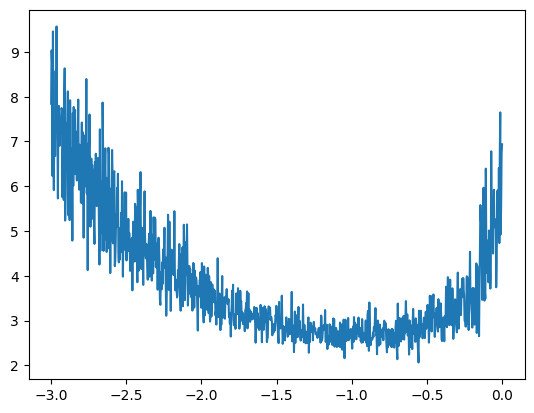

In [193]:
plt.plot(lri,lossi)

In [ ]:
'''
So based on the above plot, we can observe what is the optimal learning rate. Note the x-axis plot is lre that is the exponentail form
so we have to do 10^lre to get our learning rate.
'''

In [197]:
for i in range (100000):
  # minibatch construct
  ix = torch.randint(0,X.shape[0],(32,)) # we are creating a tuple of size 32, of number b/w 0 and size of X.

  # forward pass
  emb = C[X[ix]] # updating with ix
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Y[ix]) # updating with ix
  # print("loss:  ",loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.2 # 10^(-0.7)
  for p in parameters:
    p.data += -lr * p.grad

# print(loss.item())

Streaming output truncated to the last 5000 lines.
loss:   2.1119608879089355
loss:   2.5001072883605957
loss:   2.3356940746307373
loss:   2.1704764366149902
loss:   2.2658987045288086
loss:   2.5854287147521973
loss:   1.9384231567382812
loss:   2.319474458694458
loss:   2.5582797527313232
loss:   2.1926229000091553
loss:   2.6309690475463867
loss:   2.2509043216705322
loss:   2.2050464153289795
loss:   2.4611761569976807
loss:   2.3483200073242188
loss:   2.4236011505126953
loss:   2.851881742477417
loss:   2.462811231613159
loss:   2.161567449569702
loss:   2.6726646423339844
loss:   2.2415225505828857
loss:   2.1116724014282227
loss:   2.544194221496582
loss:   2.1690104007720947
loss:   2.6213841438293457
loss:   2.4647231101989746
loss:   1.9446074962615967
loss:   2.131898880004883
loss:   2.160304546356201
loss:   2.020883321762085
loss:   2.1574347019195557
loss:   2.305614709854126
loss:   2.887406826019287
loss:   2.370913505554199
loss:   2.3499550819396973
loss:   1.93672

In [198]:
# lets evaluate the loss for all of the dataset
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y)
print("loss:  ",loss.item())

loss:   2.3534607887268066


In [ ]:
'''
After we trained at the last we will do a learning rate decay we decay it by may 10 if it is 0.1 -> 0.01 and run the algo again
'''

In [ ]:
'''
One most important thing to note here is, we got the loss 2.35 and the bigram model had a loss of 2.45, so it means we are doing better than
the bigram model ? It's not true, because we add up more parameters and more neurons to thousands to millions, the model will start
overfitting the data so well, basically it memorises the data and we try to sample from it, we will get the exact same words as in the
data set, so what should we do is the classical split, training set (80%), validation set (10%), test set(10%).
We do the training using the training set, validation set is used to adjust/train the hyper parameters like adding more neurons or changing
the architecture etc, what works best, test set is used for evaluation/accuracy
'''

In [203]:
 # build the dataset
def build_dataset(words):
  block_size = 3 # context length : how many characters do we take to predict the next one ?
  X,Y = [],[]
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in list(w)+['<E>']:
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->',itos[ix])
      context = context[1:] + [ix]
      # print(context)
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))  # 80% of the words
n2 = int(0.9 * len(words))  # 90% of the words

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [204]:
g = torch.Generator().manual_seed(123)
C = torch.randn((28,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,28),generator=g)
b2 = torch.randn(28,generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad=True


In [205]:
for i in range (100000):
  # minibatch construct
  ix = torch.randint(0,Xtr.shape[0],(32,)) # we are creating a tuple of size 32, of number b/w 0 and size of X.

  # forward pass
  emb = C[Xtr[ix]] # updating with ix
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Ytr[ix]) # updating with ix
  # print("loss:  ",loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.2 # 10^(-0.7)
  for p in parameters:
    p.data += -lr * p.grad

print(loss.item())

2.064493417739868


In [207]:
# lets look the loss for the whole training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytr)
print("loss:  ",loss.item())

loss:   2.317795515060425


In [206]:
# lets evaluate the loss for dev set
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev)
print("loss:  ",loss.item())

loss:   2.3248095512390137


In [ ]:
'''
As we can see the training loss(on the whole training data) and the dev loss are about same, so we are not overfitting, this model is not
powerful enough to just be purely memorizing the data so far we are underfitting, so what it means is our network is very tiny and we expect
to make performance improvements by scaling up the size of the neural net
'''

In [209]:
g = torch.Generator().manual_seed(123)
C = torch.randn((28,2),generator=g)
W1 = torch.randn((6,300),generator=g)
b1 = torch.randn(300,generator=g)
W2 = torch.randn((300,28),generator=g)
b2 = torch.randn(28,generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad=True
sum(p.nelement() for p in parameters)



10584

In [230]:
# lri = []
stepi = [] # lets track the steps (i)
lossi= []
for i in range (100000):
  # minibatch construct
  ix = torch.randint(0,Xtr.shape[0],(32,)) # we are creating a tuple of size 32, of number b/w 0 and size of X.

  # forward pass
  emb = C[Xtr[ix]] # updating with ix
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Ytr[ix]) # updating with ix
  # print("loss:  ",loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.07
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.item())

# print(loss.item())

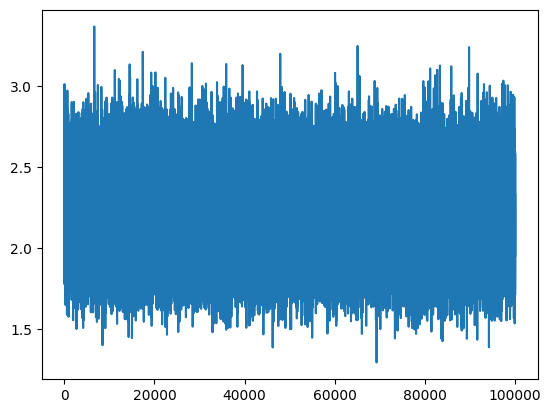

In [228]:
plt.plot(stepi,lossi)

In [ ]:
'''
In the plot we can see a lot of accumulation at the bottom, this can be because of the our small size of minibatch creating noise.
'''

In [229]:
# lets look the loss for the whole training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytr)
print("loss:  ",loss.item())

loss:   2.1924679279327393


In [231]:
# lets evaluate the loss for dev set
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev)
print("loss:  ",loss.item())

loss:   2.2198567390441895


In [ ]:
'''
As we increased the neural net size, but our loss is not that greatly reduced, our C matrix mapped to 2d maybe the bottle neck
'''

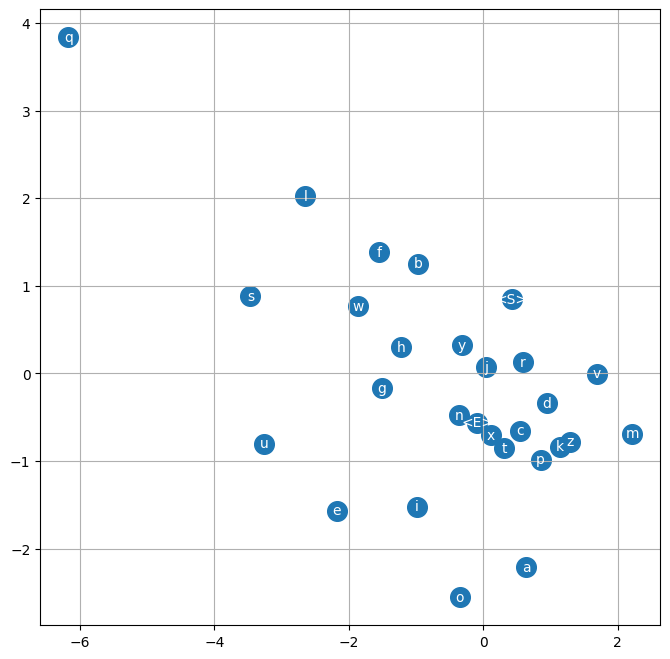

In [232]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')


In [ ]:
# Now lets make the embeddings bigger

In [233]:
g = torch.Generator().manual_seed(123)
C = torch.randn((28,10),generator=g)
W1 = torch.randn((30,200),generator=g) # also decreasing the neurons size too
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200,28),generator=g)
b2 = torch.randn(28,generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad=True
sum(p.nelement() for p in parameters)



12108

In [234]:
lri = []
stepi = [] # lets track the steps (i)
lossi= []

In [250]:

for i in range (100000):
  # minibatch construct
  ix = torch.randint(0,Xtr.shape[0],(32,)) # we are creating a tuple of size 32, of number b/w 0 and size of X.

  # forward pass
  emb = C[Xtr[ix]] # updating with ix
  h = torch.tanh(emb.view(-1,30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Ytr[ix]) # updating with ix
  # print("loss:  ",loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item()) # log loss for better visualization while plotting

# print(loss.item())

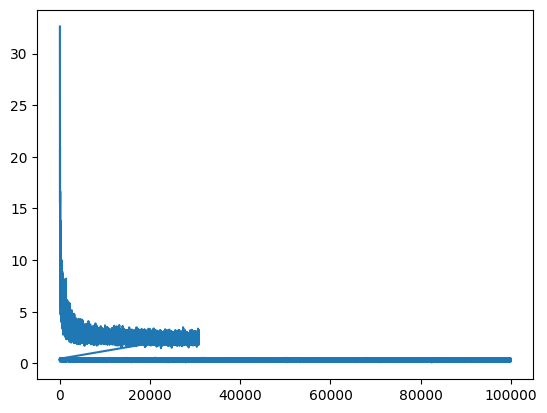

In [251]:
plt.plot(stepi,lossi)

In [252]:
# lets look the loss for the whole training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytr)
print("loss:  ",loss.item())

loss:   2.0717296600341797


In [253]:
# lets evaluate the loss for dev set
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev)
print("loss:  ",loss.item())

loss:   2.12495756149292


In [ ]:
'''
As we can see we were able to reduce the loss little bit after adjusting the C matrix, so it maybe was the bottle neck.
'''

In [ ]:
'''
Typically we would be running lots of experiments and then you are slowly stcrutinizing whichever ones give you the best performance and once
you find all the hyper parameters that make you performance good, you take that model and you evaluate the test performance single time and
that's the number we report on the papers.
'''

In [ ]:
'''
There are multiple ways we can go from here,
we can continue tuning the optimization,
or we can continue changing the parameters or the embedding dimmensionality
'''

In [267]:
C[torch.tensor([0,0,0])].view(1,-1).shape, W1.shape

(torch.Size([1, 30]), torch.Size([30, 200]))

In [268]:
from __future__ import generators
# sample from the model
g = torch.Generator().manual_seed(1236)
for i in range(1):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor(context)]
    h = torch.tanh(emb.view(1,-1) @ W1 + b1 )
    logits = h @ W2 + b2
    probs = F.softmax(logits,dim=1)
    ix = torch.multinomial(probs,num_samples=1,generator=g).item()
    context = context[1:] + [ix]
    print(context)
    out.append(ix)
    if ix == 27:
      break
  print(''.join(itos[i] for i in out))

[0, 0, 3]
[0, 3, 1]
[3, 1, 18]
[1, 18, 12]
[18, 12, 25]
[12, 25, 14]
[25, 14, 27]
carlyn<E>
